In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

E: Package 'python-software-properties' has no installation candidate


MessageError: ignored

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

In [ ]:


import os, cv2, math
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
import pickle
from tensorflow.keras.callbacks import TensorBoard

import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import np_utils
from sklearn. model_selection import train_test_split
from keras.layers import GlobalAveragePooling2D, Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_hub as hub
from tensorflow.keras.layers import BatchNormalization


#Preprocessing

##Segmentation Code Part

In [ ]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims

import cv2
import numpy as np


class skinDetector(object):

  # class constructor
  def __init__(self, imageName):
      self.image = cv2.imread(imageName)
      if self.image is None:
          print("IMAGE NOT FOUND")
          exit(1)
      # self.image = cv2.resize(self.image,(600,600),cv2.INTER_AREA)
      self.HSV_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2HSV)
      self.YCbCr_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2YCR_CB)
      self.binary_mask_image = self.HSV_image

  # ================================================================================================================================
  # function to process the image and segment the skin using the HSV and YCbCr colorspaces, followed by the Watershed algorithm
  def find_skin(self):
      self.__color_segmentation()
      output=self.__region_based_segmentation()
      return output

  # ================================================================================================================================
  # Apply a threshold to an HSV and YCbCr images, the used values were based on current research papers along with some
  # empirical tests and visual evaluation
  def __color_segmentation(self):
      lower_HSV_values = np.array([0, 40, 0], dtype="uint8")
      upper_HSV_values = np.array([25, 255, 255], dtype="uint8")

      lower_YCbCr_values = np.array((0, 138, 67), dtype="uint8")
      upper_YCbCr_values = np.array((255, 173, 133), dtype="uint8")

      # A binary mask is returned. White pixels (255) represent pixels that fall into the upper/lower.
      mask_YCbCr = cv2.inRange(self.YCbCr_image, lower_YCbCr_values, upper_YCbCr_values)
      mask_HSV = cv2.inRange(self.HSV_image, lower_HSV_values, upper_HSV_values)

      self.binary_mask_image = cv2.add(mask_HSV, mask_YCbCr)
      #self.binary_mask_image = mask_HSV

  # ================================================================================================================================
  # Function that applies Watershed and morphological operations on the thresholded image
  def __region_based_segmentation(self):
      # morphological operations
      image_foreground = cv2.erode(self.binary_mask_image, None, iterations=3)  # remove noise
      dilated_binary_image = cv2.dilate(self.binary_mask_image, None,
                                        iterations=3)  # The background region is reduced a little because of the dilate operation
      ret, image_background = cv2.threshold(dilated_binary_image, 1, 128,
                                            cv2.THRESH_BINARY)  # set all background regions to 128

      image_marker = cv2.add(image_foreground,
                              image_background)  # add both foreground and backgroud, forming markers. The markers are "seeds" of the future image regions.
      image_marker32 = np.int32(image_marker)  # convert to 32SC1 format

      cv2.watershed(self.image, image_marker32)
      m = cv2.convertScaleAbs(image_marker32)  # convert back to uint8

      # bitwise of the mask with the input image
      ret, image_mask = cv2.threshold(m, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
      output = cv2.bitwise_and(self.image, self.image, mask=image_mask)

      # show the images
      #self.show_image(self.image)
      #self.show_image(image_mask)
      #return image_mask
      #self.show_image(output)
      return output

  # ================================================================================================================================
  def show_image(self, image):
      cv2.imshow("Image", image)
      cv2.waitKey(0)
      cv2.destroyWindow("Image")

##Training Set

In [ ]:
Directory="/content/drive/MyDrive/Colab Notebooks/Sign Language recognition/Dataset/Bangla/RESIZED_Training_DATA"
Categories=['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37']
IMAGE_SIZE=124

training_data = []
i=0
for c in Categories:
    folder = os.path.join(Directory,c)
    index = Categories.index(c)
    
    for img in os.listdir(folder):
        image= os.path.join(folder,img)
        img_arr=cv2.imread(image)
        #detector = skinDetector(image)
        #img_arr = detector.find_skin()
        img_arr=cv2.resize(img_arr,(IMAGE_SIZE,IMAGE_SIZE))
        training_data.append([img_arr, index])
        #print(i)
        i=i+1
import random
random.shuffle(training_data)
for sample in training_data[:5]:
    print(sample[1])


B38TrX=[]
B38Try=[]
for features, label in training_data:
    B38TrX.append(features)
    B38Try.append(label)
B38TrnsX=np.array(B38TrX)
B38Trnsy=np.array(B38Try)

import pickle
pickle_out=open("/content/drive/MyDrive/Colab Notebooks/Sign Language recognition/Dataset/Bangla/B38TrnsX.pickle", "wb")
pickle.dump(B38TrnsX,pickle_out)
pickle_out.close()


pickle_out=open("/content/drive/MyDrive/Colab Notebooks/Sign Language recognition/Dataset/Bangla/B38Trnsy.pickle", "wb")
pickle.dump(B38Trnsy,pickle_out)
pickle_out.close()


KeyboardInterrupt: ignored

#Training With Augmentation

In [ ]:
from numpy import expand_dims
Directory="/content/drive/MyDrive/Colab Notebooks/Sign Language recognition/Dataset/Bangla/RESIZED_Training_DATA"
Categories=['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37']
Img_size=124
Channel=3

training_data = []
i=0
for c in Categories:
    folder = os.path.join(Directory,c)
    index = Categories.index(c)
    
    for img in os.listdir(folder):
        image= os.path.join(folder,img)
        img_arr=cv2.imread(image)
        #detector = skinDetector(image)
        #img_arr = detector.find_skin()
        img_resized=cv2.resize(img_arr,(Img_size,Img_size))
        training_data.append([img_resized, index])
        
        img_resized= expand_dims(img_resized, 0)
        img_resized = expand_dims(img_resized, 3)
        #print(img_resized.shape)
        img_resized = img_resized.reshape(1, Img_size, Img_size, Channel)

        datagenrot = ImageDataGenerator(rotation_range=30)
        igr = datagenrot.flow(img_resized, batch_size=1)

        datagenscal = ImageDataGenerator(zoom_range = .50)
        igs = datagenscal.flow(img_resized, batch_size=1)

        datagentrans = ImageDataGenerator(shear_range=-0.2)
        igt = datagentrans.flow(img_resized, batch_size=1)

        datagenwidthshift = ImageDataGenerator(height_shift_range=0.2)
        wshift = datagenwidthshift.flow(img_resized, batch_size=1)

        datagenheightshift = ImageDataGenerator(width_shift_range=0.2)
        heightshift = datagenheightshift.flow(img_resized, batch_size=1)
        
        horizontal_flip = ImageDataGenerator(horizontal_flip=True)
        hflip = horizontal_flip.flow(img_resized, batch_size=1)
        
        brithness = ImageDataGenerator(brightness_range=[0.2,1.0])
        bright= brithness.flow(img_resized, batch_size=1)


        for i in range(1):
            batch1 = igr.next()
            Images = batch1[0].astype('uint8')
            Images=Images.reshape(Img_size, Img_size, Channel)
            training_data.append([Images, index])


            batch3 = igs.next()
            Images = batch3[0].astype('uint8')
            Images = Images.reshape(Img_size, Img_size, Channel)
            training_data.append([Images, index])

            #plt.imshow(Images)
            #plt.show()

            batch2 = igt.next()
            Images = batch2[0].astype('uint8')
            Images = Images.reshape(Img_size, Img_size, Channel)
            training_data.append([Images, index])

            # plt.imshow(Images)
            #plt.show()
            #break
            batch4 = wshift.next()
            Images = batch4[0].astype('uint8')
            Images = Images.reshape(Img_size, Img_size, Channel)
            training_data.append([Images, index])

            batch5 = heightshift.next()
            Images = batch5[0].astype('uint8')
            Images = Images.reshape(Img_size, Img_size, Channel)
            training_data.append([Images, index])
            """     
            batch6 = hflip.next()
            Images = batch6[0].astype('uint8')
            Images = Images.reshape(Img_size, Img_size, Channel)
            training_data.append([Images, index])

            batch7 = bright.next()
            Images = batch7[0].astype('uint8')
            Images = Images.reshape(Img_size, Img_size, Channel)
            training_data.append([Images, index])
            """
         

        #print(i)
        i=i+1


import random
random.shuffle(training_data)
for sample in training_data[:5]:
    print(sample[1])


B38TrX=[]
B38Try=[]
for features, label in training_data:
    B38TrX.append(features)
    B38Try.append(label)
B38TrnsX_aug=np.array(B38TrX)
B38Trnsy_aug=np.array(B38Try)

import pickle
pickle_out=open("/content/drive/MyDrive/Colab Notebooks/Sign Language recognition/Dataset/Bangla/B38TrnsX_aug.pickle", "wb")
pickle.dump(B38TrnsX_aug,pickle_out)
pickle_out.close()


pickle_out=open("/content/drive/MyDrive/Colab Notebooks/Sign Language recognition/Dataset/Bangla/B38Trnsy_aug.pickle", "wb")
pickle.dump(B38Trnsy_aug,pickle_out)
pickle_out.close()


4
12
32
25
1


##Test Set

In [ ]:
Directory="/content/drive/MyDrive/Colab Notebooks/Sign Language recognition/Dataset/Bangla/RESIZED_TESTING_DATA"
Categories=['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37']
IMAGE_SIZE=124

training_data = []
i=0
for c in Categories:
    folder = os.path.join(Directory,c)
    index = Categories.index(c)
    
    for img in os.listdir(folder):
        image= os.path.join(folder,img)
        img_arr=cv2.imread(image)
        #detector = skinDetector(image)
        #img_arr = detector.find_skin()
        img_arr=cv2.resize(img_arr,(IMAGE_SIZE,IMAGE_SIZE))
        training_data.append([img_arr, index])
        #print(i)
        i=i+1
import random
random.shuffle(training_data)
for sample in training_data[:5]:
    print(sample[1])


B38VX=[]
B38Vy=[]
for features, label in training_data:
    B38VX.append(features)
    B38Vy.append(label)
B38VnsX=np.array(B38VX)
B38Vnsy=np.array(B38Vy)

import pickle
pickle_out=open("/content/drive/MyDrive/Colab Notebooks/Sign Language recognition/Dataset/Bangla/B38VnsX.pickle", "wb")
pickle.dump(B38VnsX,pickle_out)
pickle_out.close()

pickle_out=open("/content/drive/MyDrive/Colab Notebooks/Sign Language recognition/Dataset/Bangla/B38Vnsy.pickle", "wb")
pickle.dump(B38Vnsy,pickle_out)
pickle_out.close()


#Load Segmentation Data

#Load Not Segmentation Data

In [ ]:
path="/content/drive/MyDrive/Colab Notebooks/Sign Language recognition/Dataset/Bangla"

X_Train=pickle.load(open(os.path.join(path,"B38TrnsX.pickle"),"rb"))
Y_train=pickle.load(open(os.path.join(path,"B38Trnsy.pickle"),"rb"))
X_Test=pickle.load(open(os.path.join(path,"B38VnsX.pickle"),"rb"))
Y_test=pickle.load(open(os.path.join(path,"B38Vnsy.pickle"),"rb"))


#Load Augmentation

In [ ]:
path="/content/drive/MyDrive/Colab Notebooks/Sign Language recognition/Dataset/Bangla"

X_Train=pickle.load(open(os.path.join(path,"B38TrnsX_aug.pickle"),"rb"))
Y_train=pickle.load(open(os.path.join(path,"B38Trnsy_aug.pickle"),"rb"))
X_Test=pickle.load(open(os.path.join(path,"B38VnsX.pickle"),"rb"))
Y_test=pickle.load(open(os.path.join(path,"B38Vnsy.pickle"),"rb"))
print(X_Train.shape)
print(X_Test.shape)
print(Y_train.shape)
print(Y_test.shape)

(66426, 124, 124, 3)
(1520, 124, 124, 3)
(66426,)
(1520,)


In [ ]:
print(X_Train.shape)
print(X_Test.shape)
print(Y_train.shape)
print(Y_test.shape)

(11071, 124, 124, 3)
(1520, 124, 124, 3)
(11071,)
(1520,)


In [ ]:
import os, cv2, math
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import pickle
from tensorflow.keras.callbacks import TensorBoard
import time
IMAGE_SIZE=124

class_labels=38
CHANNEL=3

from keras.utils import np_utils
from sklearn. model_selection import train_test_split
x_train, x_test,y_train,y_test=X_Train,X_Test,Y_train,Y_test
print('x train shape', x_train.shape)
print('y train shape',y_train.shape)
print('x test shape',x_test.shape)
print('y test shape',y_test.shape)
#
y_train_ml=y_train
y_test_ml=y_test
# Flattening the images from the 28x28 pixels to 1D 787 pixels
#x_train = x_train.reshape(-1, 1600)
#x_test = x_test.reshape(-1, 1600)

#from sklearn import preprocessing
#import numpy as np
#x_train=preprocessing.StandardScaler().fit(x_train)
#x_test=preprocessing.StandardScaler().fit(x_test)
#x_train=np.array(x_train)
#x_test=np.array(x_test)

# normalizing the data to help with the training
#x_train /= 255.0
#x_test /= 255.0
#x_train/= 255.
#x_train -= 0.5
#x_train*= 2.

#x_test/= 255.
#x_test -= 0.5
#x_test*= 2.



x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# one-hot encoding using keras' numpy-related utilities
n_classes = 38
print("Shape before one-hot encoding: ", y_train.shape)
y_train = np_utils.to_categorical(y_train, n_classes)
y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: for y train", y_train.shape)
print("Shape after one-hot encoding: for y test", y_test.shape)

x train shape (11071, 124, 124, 3)
y train shape (11071,)
x test shape (1520, 124, 124, 3)
y test shape (1520,)
Shape before one-hot encoding:  (11071,)
Shape after one-hot encoding: for y train (11071, 38)
Shape after one-hot encoding: for y test (1520, 38)


In [ ]:
print(x_train.shape)

NameError: ignored

#All Package

In [ ]:
import pickle
import numpy as np
import numpy as np
import time
import sklearn
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D,BatchNormalization, Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras import optimizers
# import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
#from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
#from mlxtend.plotting import plot_decision_regions

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import os, cv2, math
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import pickle
from tensorflow.keras.callbacks import TensorBoard
import time
import datetime
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import pickle
from tensorflow.keras.callbacks import TensorBoard

images_train=x_train
class_train=y_train 
images_test=x_test
class_test=y_test

#Model

##1. Cipher Model

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from keras.models import Sequential

#from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.constraints import maxnorm
from keras.models import load_model
from keras.layers import GlobalAveragePooling2D, Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
from keras.preprocessing.image import ImageDataGenerator

matplotlib.style.use('ggplot')

# Hight and width of th
# 3 channels, Red, Green and Blue
CHANNELS = 3
# Number of epochs
NUM_EPOCH = 50
# learning rate
LEARN_RATE = 1.0e-4

images_train=x_train.reshape(-1,IMAGE_SIZE ,IMAGE_SIZE ,3)
class_train=labels_train=y_train
images_test=x_test.reshape(-1,IMAGE_SIZE ,IMAGE_SIZE ,3)
class_test=labels_test=y_test

print("Training set size:\t",len(images_train))
print("Testing set size:\t",len(images_test))

def pure_cnn_model():
    
    model = Sequential()
    
    model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS)))    
    model.add(Dropout(0.2))
     
    model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same'))  
    model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', strides = 2))    
    model.add(Dropout(0.5))
    
    model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))    
    model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))
    model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same', strides = 2))    
    model.add(Dropout(0.5))    
    
    model.add(Conv2D(192, (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(Conv2D(192, (1, 1),padding='valid'))
    model.add(Activation('relu'))
    model.add(Conv2D(38, (1, 1), padding='valid'))
    model.add(GlobalAveragePooling2D())
    
    model.add(Activation('softmax'))
    model.summary()
    
    return model
#Save the model after every epoch
checkpoint = ModelCheckpoint('best_model_improved.h5',  # model filename
                             monitor='val_loss', # quantity to monitor
                             verbose=0, # verbosity - 0 or 1
                             save_best_only= True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor


In [ ]:
model = pure_cnn_model()                                        

model.compile(loss='categorical_crossentropy', # Better loss function for neural networks
              optimizer='adam', # Adam optimizer with 1.0e-4 learning rate
              metrics = ['accuracy']) # Metrics to be evaluated by the model

model_details = model.fit(images_train, class_train,
                    batch_size = 128,
                    epochs = NUM_EPOCH, # number of iterations
                    validation_data= (images_test, class_test),
                    callbacks=[checkpoint],  verbose=1)


#hadi

#Hadi code  93%

In [ ]:

NUM_EPOCH = 500
# learning rate
LEARN_RATE = 1.0e-4
nb_classes=38

from keras.preprocessing.image import ImageDataGenerator
# Image Augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

datagen.fit(images_train)


# Create CNN model
model = Sequential()

model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNEL)))    
model.add(Dropout(0.2))                                                                                                   

model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same'))  
model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', strides = 2))    
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))    
model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))
model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same', strides = 2))    
model.add(Dropout(0.5))    
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(192, (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(192, (1, 1),padding='valid'))
model.add(Activation('relu'))
model.add(Conv2D(38, (1, 1), padding='valid'))

model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())

model.add(Activation('softmax'))  
                             
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 96)      2688      
                                                                 
 dropout (Dropout)           (None, 124, 124, 96)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 96)      83040     
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 96)        83040     
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 96)       0         
 )                                                               
                                                        

In [ ]:
model=[]

In [ ]:
model.compile(loss='categorical_crossentropy', # Better loss function for neural networks
              optimizer=Adam(learning_rate=LEARN_RATE), # Adam optimizer with 1.0e-4 learning rate
              metrics = ['accuracy']) # Metrics to be evaluated by the model


model_details = model.fit(images_train, class_train,
                    batch_size = 128,
                    epochs = NUM_EPOCH, # number of iterations
                    validation_data= (images_test, class_test),  verbose=1)

NameError: ignored

#confusion matrix

12/12 [==============================] - 1s 73ms/step


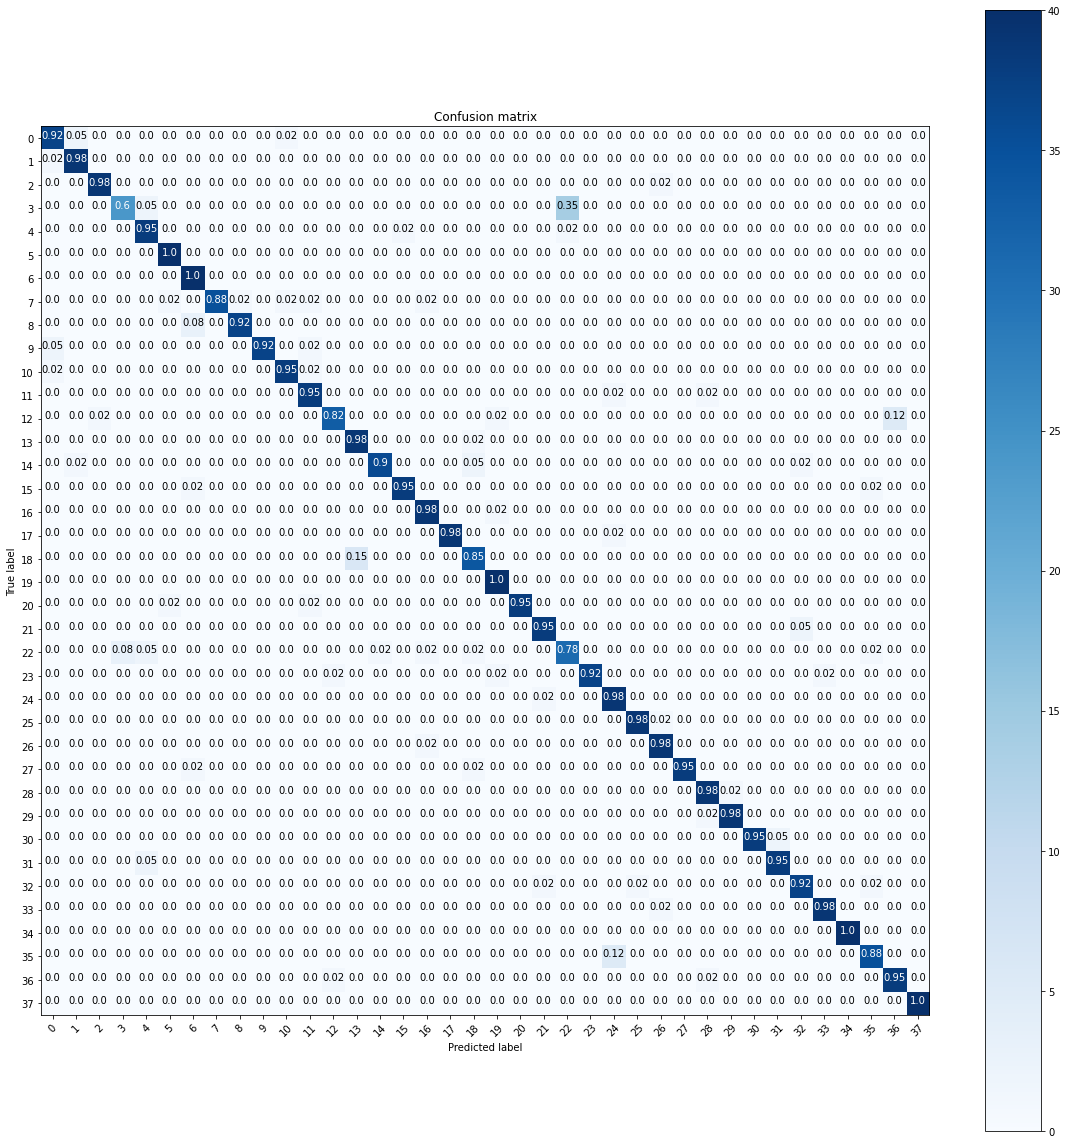

In [ ]:
class_names=['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37']
x_test = x_test.reshape(x_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3)
prediction=model.predict(x_test, batch_size=128, verbose=1)
#prediction_class=success_rate.predict_classes(x_test, batch_size=128, verbose=0)
rounded_predictions=np.argmax(prediction, axis=1)

# Calculate the confusion matrix using sklearn.metrics
cm = sklearn.metrics.confusion_matrix(y_test_ml, rounded_predictions)
    
figure = plot_confusion_matrix(cm, class_names=class_names)


#cm_image = plot_to_image(figure)

    
    # Log the confusion matrix as an image summary.
#with file_writer_cm.as_default():
      #tf.summary.image("Confusion Matrix", cm_image, step=epoch)



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
result_rf = confusion_matrix(y_test_ml, rounded_predictions)

result1_rf = classification_report(y_test_ml, rounded_predictions)
print("\nClassification Report for pca & random forest:",)
print (result1_rf)




Classification Report for pca & random forest:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91        40
           1       0.93      0.97      0.95        40
           2       0.97      0.97      0.97        40
           3       0.89      0.60      0.72        40
           4       0.86      0.95      0.90        40
           5       0.95      1.00      0.98        40
           6       0.89      1.00      0.94        40
           7       1.00      0.88      0.93        40
           8       0.97      0.93      0.95        40
           9       1.00      0.93      0.96        40
          10       0.95      0.95      0.95        40
          11       0.90      0.95      0.93        40
          12       0.94      0.82      0.88        40
          13       0.87      0.97      0.92        40
          14       0.97      0.90      0.94        40
          15       0.97      0.95      0.96        40
          16       0.93      0.97

In [ ]:
from keras.callbacks import TensorBoard
def plot_confusion_matrix(cm, class_names):
    import itertools
    import io
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(16, 16))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure
from datetime import datetime
import keras
logdir = "logs/fit" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir = logdir, histogram_freq = 1)
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')

def plot_to_image(figure):
    import io
    """
    Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call.
    """
    
    buf = io.BytesIO()
    
    # Use plt.savefig to save the plot to a PNG in memory.
    plt.savefig(buf, format='png')
    
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    
    # Use tf.image.decode_png to convert the PNG buffer
    # to a TF image. Make sure you use 4 channels.
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    
    # Use tf.expand_dims to add the batch dimension
    image = tf.expand_dims(image, 0)
    
    return image
epoch=10
def log_confusion_matrix(epoch, logs):
    
    # Use the model to predict the values from the test_images.
    test_pred_raw = model.predict(test_images)
    
    test_pred = np.argmax(test_pred_raw, axis=1)
    
    # Calculate the confusion matrix using sklearn.metrics
    cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
    
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)
    
    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)
#cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [ ]:

history=model.fit_generator(datagen.flow(images_train, class_train, batch_size = 128),
                    steps_per_epoch = 128, # number of samples per gradient update
                    epochs = 500, # number of iterations
                    validation_data= (images_test, class_test),
                    
                    verbose=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/500
128/128 [==============================] - 40s 307ms/step - loss: 0.6724 - accuracy: 0.8259 - val_loss: 0.8052 - val_accuracy: 0.8849
